**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent the problems while reloading the Project. The third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING THE DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the Project in one particular cell.

In [3]:
#@ DOWNLOADING THE DEPENDENCIES: UNCOMMENT BELOW:
# !pip install kora -q                                        # Installing the Dependencies for RDKIT.
import kora.install.rdkit                                     # Getting RDKIT. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as display

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

**GETTING THE DATA:**
- I have downloaded the dataset from [ExcapeDB](https://solr.ideaconsult.net/search/excape/). **ExcapeDB** is a project developed as a part of **BigChem**. I will read the data using pandas and manage the dataset. 

In [4]:
#@ GETTING THE DATA:
PATH = "/content/drive/MyDrive/WORK/Data1.csv"                 # Path to the Data.
data = pd.read_csv(PATH)                                       # Reading the Data.
data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZMKBJHIXZCVNL-BXKDBHETNA-N,44590643,6532,A,5.68382,pubchem,393260,9606,SLC6A4,4061,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1
1,AZMKBJHIXZCVNL-UHFFFAOYNA-N,11492305,6532,A,5.16210,pubchem,393258,9606,SLC6A4,4061,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1
2,AZOHUEDNMOIDOC-GETDIYNLNA-N,44419340,6532,A,6.66354,pubchem,276059,9606,SLC6A4,4061,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...
3,AZSKJKSQZWHDOK-VJSLDGLSNA-N,CHEMBL1080745,6532,A,6.96000,chembl20,617082,9606,SLC6A4,4061,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...
4,AZTPZTRJVCAAMX-UHFFFAOYNA-N,CHEMBL578346,6532,A,8.00000,chembl20,596934,9606,SLC6A4,4061,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2


### **PREPARING THE DATA:**

,SMILES,Molecule
0,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1,
1,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1,
2,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...,
3,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...,
4,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2,

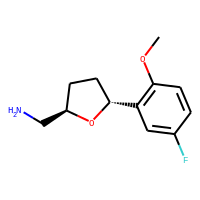
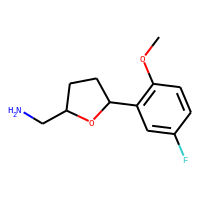
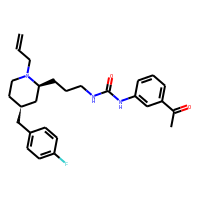
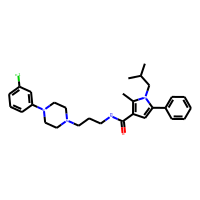
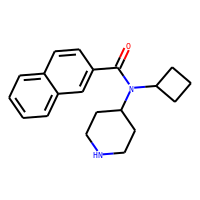

In [5]:
#@ DATA EXPLORATION:
PandasTools.AddMoleculeColumnToFrame(data, "SMILES", "Molecule")
data[["SMILES", "Molecule"]].head()                                    # Inspecting the Data.

In [6]:
#@ DATA EXPLORATION:
data.Molecule.isna().sum()                # Inspecting the Null values. 

0

**VECTORIZING THE MOLECULES:**
- I will convert the molecules into vectors of numbers that can be used for modelling. I will also convert the fingerprint of molecular number into little image. 

In [7]:
#@ VECTORIZING THE MOLECULES:
def mol2fp(mol):                                                  # Function to convert Molecules into Fingerprints. 
  fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
  array = np.zeros((1, ), dtype=np.int8)                          # Initializing the array.
  DataStructs.ConvertToNumpyArray(fp, array)
  return array
fp = mol2fp(Chem.MolFromSmiles(data.loc[1, "SMILES"]))            # Invoking the Function above. 
data["FPs"] = data.Molecule.apply(mol2fp)                         # Adding the new column to the DataFrame. 

**PREPARING THE DATA:**
- **PyTorch** needs to be trained on tensors. I will divide the dataset into train, validation and test dataset. 

In [8]:
#@ PREPARING THE DATA:
X = np.stack(data.FPs.values)
print(X.shape)                                                                              # Inspecting the shape of Data. 
y = data.pXC50.values.reshape((-1, 1))                            
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)  # Splitting the Data into Training and Test. 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.05, 
                                                      random_state=42)                      # Splitting the Data into Training and Validation. 
#@ NORMALIZATION:
scaler = StandardScaler()                                                                   # Initializing the Standard Scaler. 
y_train = scaler.fit_transform(y_train)                                                     # Normalizing the Data.
y_test = scaler.transform(y_test)                                                           # Normalizing the Data.
y_valid = scaler.transform(y_valid)                                                         # Normalizing the Data.
#@ REMOVING LOW VARIANCE FEATURES:
feature_select = VarianceThreshold(threshold=0.05)                                          # Initializing the Variance. 
X_train = feature_select.fit_transform(X_train)                                             # Normalizing the Data.
X_valid = feature_select.transform(X_valid)                                                 # Normalizing the Data.
X_test = feature_select.transform(X_test)                                                   # Normalizing the Data.
print(X_train.shape, X_test.shape, X_valid.shape)                                           # Inspecting the shape of Data. 

(7228, 4096)
(6179, 221) (723, 221) (326, 221)


**PREPARING THE DATA:**

In [9]:
#@ PREPARING THE DATA:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                     # Inspecting if CUDA is available. 
X_train = torch.tensor(X_train, device=device).float()                                    # Converting into GPU Tensors. 
X_test = torch.tensor(X_test, device=device).float()                                      # Converting into GPU Tensors. 
X_valid = torch.tensor(X_valid, device=device).float()                                    # Converting into GPU Tensors. 
y_train = torch.tensor(y_train, device=device).float()                                    # Converting into GPU Tensors. 
y_test = torch.tensor(y_test, device=device).float()                                      # Converting into GPU Tensors. 
y_valid = torch.tensor(y_valid, device=device).float()                                    # Converting into GPU Tensors. 
print(type(X_train), X_train.shape)                                                       # Inspecting the Data. 

<class 'torch.Tensor'> torch.Size([6179, 221])


**PREPARING THE DATASETS:**
- **PyTorch** works with datasets and dataloaders to feed the minibatches to the model during training. The trainloader will shuffle the data when an epoch has been used. 

In [20]:
#@ PREPARING THE DATASETS:
train_data = TensorDataset(X_train, y_train)                                     # Preparing the Training Dataset. 
valid_data = TensorDataset(X_valid, y_valid)                                     # Preparing the Validation Dataset. 
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=256, shuffle=True)         # Preparing the Train Loader. 
valid_loader = torch.utils.data.DataLoader(dataset=valid_data, 
                                           batch_size=256, shuffle=True)         # Preparing the Validation Loader.                  

### **BUILDING THE MODEL:**
- I will define a **Neural Network Model** using the subclassing. There is no activation function for the final output as this is a regression model. 

In [49]:
#@ BUILDING THE MODEL:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_rate, output_size):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)                             # Full connected Simple Linear Layer. 
    self.fc2 = nn.Linear(hidden_size, hidden_size)                            # Full connected Simple Linear Layer.
    self.fc3 = nn.Linear(hidden_size, hidden_size)                            # Full connected Simple Linear Layer.
    self.fc_out = nn.Linear(hidden_size, output_size)                         # Output Layer. 
    self.ln1 = nn.LayerNorm(hidden_size)                                      # Layer Normalization to enhance speed. 
    self.ln2 = nn.LayerNorm(hidden_size)                                      # Layer Normalization to enhance speed. 
    self.ln3 = nn.LayerNorm(hidden_size)                                      # Layer Normalization to enhance speed. 
    self.activation = nn.SELU()                                          # Activation Function. 
    self.dropout = nn.Dropout(dropout_rate)                                   # Dropout Layer for Normalization. 
  def forward(self, x):
    out = self.fc1(x)
    out = self.ln1(out)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.ln2(out)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.ln2(out)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.fc3(out)
    out = self.ln3(out)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.fc_out(out)
    return out
#@ DEFINING THE HYPERPARAMETERS:
input_size = X_train.size()[-1]                                               # Input size. 
hidden_size = 1024                                                            # Size of hidden layer. 
dropout_rate = 0.50                                                           # Dropout rate. 
output_size = 1
learning_rate = 0.0001                                                         # Learning rate for Optimizer. 
model = Net(input_size, hidden_size, dropout_rate, output_size)               # Instantiating the Model. 
model.cuda()                                                                  # Moving the Model to GPU. 

Net(
  (fc1): Linear(in_features=221, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): SELU()
  (dropout): Dropout(p=0.5, inplace=False)
)

**PROCESSING THE MODEL:**

In [50]:
#@ PROCESSING THE MODEL:
loss_fn = nn.MSELoss()                                                    # Initializing the Loss Function. 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        # Initializing the Optimizer. 
#@ COMPILING AND TRAINING THE MODEL:
model.train()                                                             # Training the Model.
epochs = 500
for i in range(epochs):
  running_loss = 0
  for fps, labels in train_loader:
    optimizer.zero_grad()                                                 # Initializing the Gradients. 
    output = model(fps)                                                   # Forward pass of the minibatch. 
    loss = loss_fn(output, labels)                                        # Computing the Loss. 
    optimizer.step()                                                      # Optimizing the weights. 
    running_loss += loss.item()
  else:
    if i%10 == 0:
      valid_loss = torch.mean((y_valid - model(X_valid)) ** 2)
      print("Epoch: %3i Training Loss: %0.2F Validation Loss: %0.2F"%(
          i, (running_loss / len(train_loader)), valid_loss
      ))

Epoch:   0 Training Loss: 1.60 Validation Loss: 1.64
Epoch:  10 Training Loss: 1.63 Validation Loss: 1.64
Epoch:  20 Training Loss: 1.61 Validation Loss: 1.43
Epoch:  30 Training Loss: 1.62 Validation Loss: 1.62
Epoch:  40 Training Loss: 1.63 Validation Loss: 1.55
Epoch:  50 Training Loss: 1.66 Validation Loss: 1.64
Epoch:  60 Training Loss: 1.58 Validation Loss: 1.45
Epoch:  70 Training Loss: 1.57 Validation Loss: 1.51
Epoch:  80 Training Loss: 1.63 Validation Loss: 1.55
Epoch:  90 Training Loss: 1.55 Validation Loss: 1.62
Epoch: 100 Training Loss: 1.63 Validation Loss: 1.40
Epoch: 110 Training Loss: 1.62 Validation Loss: 1.53
Epoch: 120 Training Loss: 1.60 Validation Loss: 1.41
Epoch: 130 Training Loss: 1.64 Validation Loss: 1.46
Epoch: 140 Training Loss: 1.61 Validation Loss: 1.39
Epoch: 150 Training Loss: 1.63 Validation Loss: 1.59
Epoch: 160 Training Loss: 1.61 Validation Loss: 1.53
Epoch: 170 Training Loss: 1.55 Validation Loss: 1.43
Epoch: 180 Training Loss: 1.58 Validation Loss

**MODEL EVALUATION:**
- Before using the model for prediction, it must be set to the evaluation mode, where the dropout layers are no longer active. 

In [51]:
#@ MODEL EVALUATION:
model.eval()                                            # Switching to evaluation mode. 
y_pred_train = model(X_train)                           # Predicting the Training Data. 
y_pred_valid = model(X_valid)                           # Predicting the Validation Data. 
y_pred_test = model(X_test)                             # Predicting the Test Data. 
print(torch.mean((y_train - y_pred_train)**2).item())   # Inspecting the result. 
print(torch.mean((y_valid - y_pred_valid)**2).item())   # Inspecting the result. 
print(torch.mean((y_test - y_pred_test)**2).item())     # Inspecting the result. 

1.1837108135223389
1.1208844184875488
1.1974931955337524


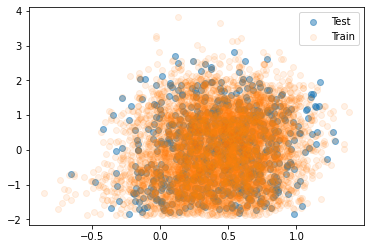

In [52]:
#@ MODEL EVALUATION:
def flatten(tensor):
  return tensor.cpu().detach().numpy().flatten()
#@ DATA VISUALIZATION:
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.show()                                                                          # Data Visualization.

In [54]:
#@ MODEL PREDICTION:
def predict_smiles(smiles):
  fp = mol2fp(Chem.MolFromSmiles(smiles)).reshape(1, -1)
  fp_filtered = feature_select.transform(fp)
  fp_tensor = torch.tensor(fp_filtered, device=device).float()
  prediction = model(fp_tensor)
  pXC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
  return pXC50[0][0]
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

7.6689425